In [28]:
#%% Libraries import
# import HiDeNN library
import sys  
sys.path.insert(1, '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d')

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions
from Bin.PDE_Library import Strain, Stress,VonMises_plain_strain
# Import Training funcitons
from Bin.Training import Training_2D_FEM
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [29]:
Default_config_file = '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_2D.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in /Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_2D.toml


In [33]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "../2D_example/eval_coordinates.npy"
num_displ_file = "../2D_example/num_solution/num_displacement.npy"
num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = [2.0, 1.0, 0.5, 0.25, 0.125]
config["solver"]["FrozenMesh"] = True
optimizers = ["adam","lbfgs"]

error_u = numpy.zeros((len(element_size),len(optimizers)))
error_v = numpy.zeros((len(element_size),len(optimizers)))
error_stress = numpy.zeros((len(element_size),len(optimizers)))
error_stress_max = numpy.zeros((len(element_size),len(optimizers)))

for e in range(len(element_size)):
    config["interpolation"]["MaxElemSize2D"] = element_size[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # Young Modulus
                                        coef2     = config["material"]["mu"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4658e+00
epoch 500 loss = 1.2127e+00
epoch 1000 loss = 9.4502e-01
epoch 1500 loss = 9.4104e-01
epoch 1543 loss = 9.4103e-01
*************** END FIRST PHASE ***************

* Training time: 7.123976945877075s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.004616964968164015s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4117e-01
epoch 4 loss = 9.4102e-01
*************** END FIRST PHASE ***************

* Training time: 0.11731600761413574s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.029329001903533936s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 1.5138e+01
epoch 500 loss = 1.6984e+00
epoch 1000 loss = 8.7944e-01
epoch 1478 loss = 8.7172e-01
*************** END FIRST PHASE ***************

* Training time: 17.23633098602295s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.011661928948594687s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.8282e-01
epoch 5 loss = 8.7171e-01
*************** END FIRST PHASE ***************

* Training time: 0.6018378734588623s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.12036757469177246s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 2.6950e+01
epoch 500 loss = 2.5079e+00
epoch 1000 loss = 8.5948e-01
epoch 1447 loss = 8.4203e-01
*************** END FIRST PHASE ***************

* Training time: 54.19909477233887s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.03745618159802271s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 1.4611e+00
epoch 5 loss = 8.4229e-01
epoch 8 loss = 8.4197e-01
*************** END FIRST PHASE ***************

* Training time: 3.654604911804199s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.4568256139755249s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       3384
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 5.3351e+01
epoch 500 loss = 4.3659e+00
epoch 1000 loss = 8.7490e-01
epoch 1500 loss = 8.3269e-01
epoch 1527 loss = 8.3267e-01
*************** END FIRST PHASE ***************

* Training time: 219.1753478050232s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.14353329915194707s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       3384
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 2.9088e+00
epoch 5 loss = 9.5209e-01
epoch 10 loss = 8.3262e-01
epoch 13 loss = 8.3261e-01
*************** END FIRST PHASE ***************

* Training time: 25.575273036956787s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 1.967328695150522s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       13728
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 1.1024e+02
epoch 500 loss = 8.8472e+00
epoch 1000 loss = 1.0318e+00
epoch 1500 loss = 8.4087e-01
epoch 2000 loss = 8.3071e-01
epoch 2101 loss = 8.3043e-01
*************** END FIRST PHASE ***************

* Training time: 1534.3665461540222s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.7303029729433709s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       13728
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.7976e+00
epoch 5 loss = 1.4736e+00
epoch 10 loss = 8.7149e-01
epoch 15 loss = 8.3127e-01
epoch 20 loss = 8.3000e-01
epoch 24 loss = 8.3e-01
*************** END FIRST PHASE ***************

* Training time: 245.36585879325867s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 10.22357744971911s


In [34]:
print("Adam")
print("u = ", error_u[:,0])
print("v = ", error_v[:,0])
print("s = ", error_stress[:,0])
print("s max = ", error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", error_u[:,1])
print("v = ", error_v[:,1])
print("s = ", error_stress[:,1])
print("s max = ", error_stress_max[:,1])

Adam
u =  [0.18775588 0.10230352 0.04060538 0.02128754 0.07499295]
v =  [0.02596945 0.01084645 0.00363882 0.00121237 0.00198047]
s =  [0.22971469 0.14722798 0.0826846  0.0434168  0.02648678]
s max =  [0.65595128 0.77592806 0.93797397 0.95504362 0.99851   ]

LBFGS
u =  [0.18588991 0.10080447 0.03665099 0.00976881 0.00178625]
v =  [0.02586959 0.01065384 0.00328927 0.00083952 0.00015972]
s =  [0.22989806 0.14733525 0.08272104 0.04314679 0.02197644]
s max =  [0.65594826 0.77632042 0.93821257 0.95494309 0.99339041]


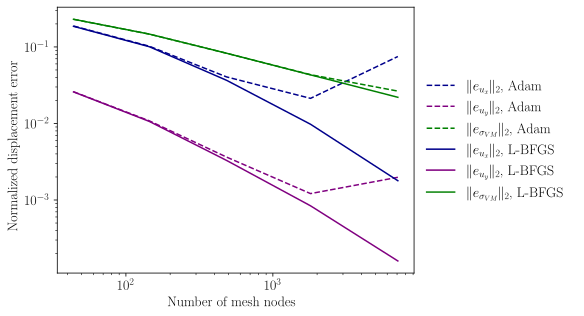

In [40]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,0],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_v[:,0],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_stress[:,0],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam")

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")


ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()
